# Cyclical Encoding of Datetime

Dates and time are cyclical features, e.g., we reset from the 12th month back to the 1st.
- there are some exceptions to this, for example, years should be numerical and not cyclical

Traditionally, date and time have often been encoded as numerical or one-hot categorical.

However this does not represent their cyclical nature and the relationship between times. 

For example, with numerical data 23:55 and 00:05 appear at opposite ends of the scale but are only 00:10 apart, which is overhead the model may need to learn. 

With one-hot data, again the relationship between time buckets can be lost. And if there is little data in a time bucket it may not be able to learn its relationship to its neighbor. 


In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt 

from datetime import datetime
from enum import Enum
from dataclasses import dataclass

## Parsing a string into a datetime object
This allows us to easily extract properties such as year, days, hours, minutes

In [2]:
def parse_time(time_string):
    return datetime.strptime(time_string, "%Y-%m-%d %H:%M")

parse_time('2012-01-01 00:00')

datetime.datetime(2012, 1, 1, 0, 0)

## Encode as cyclical sin/cos waves

In [3]:
class BaseCyclicalEncoder:
    def __init__(self, max_value, name=None):
        self.max_value = max_value
        self.prefix = name+'_' if name else ''

    def __call__(self, dt):
        value = self.get_value(dt) / self.max_value
        return {
            f'{self.prefix}sin_encoding': math.sin(2*math.pi*value),
            f'{self.prefix}cos_encoding': math.cos(2*math.pi*value)
        }

    def get_value(self, dt):
        raise NotImplemented

class MonthCyclicalEncoder(BaseCyclicalEncoder):
    """Encode month to a positional sin/cos wave"""
    def __init__(self):
        super().__init__(12, 'month')

    def get_value(self, dt):
        return dt.month

class WeekdayCyclicalEncoder(BaseCyclicalEncoder):
    """Encode weekday to a positional sin/cos wave"""
    def __init__(self):
        super().__init__(7, 'weekday')

    def get_value(self, dt):
        return dt.weekday()

class HourCyclicalEncoder(BaseCyclicalEncoder):
    """Encode hours to a positional sin/cos wave"""
    def __init__(self):
        super().__init__(24, 'hour')

    def get_value(self, dt):
        return dt.hour

class MinuteCyclicalEncoder(BaseCyclicalEncoder):
    """Encode minutes to a positional sin/cos wave"""
    def __init__(self):
        super().__init__(60, 'minute')

    def get_value(self, dt):
        return dt.minute


class DatetimeEncoder:
    """Encode datetime using a list of separate encoders. Requires all encoders to give unique values"""
    def __init__(self):
        self.encoders = [
            MonthCyclicalEncoder(),
            WeekdayCyclicalEncoder(),
            HourCyclicalEncoder(),
            MinuteCyclicalEncoder(),
        ]

    def __call__(self, dt):
        results = [encoder(dt) for encoder in self.encoders]
        return {k:v for result in results for k,v in result.items()}

## Testing

In [4]:
def get_time_range(start, end, n=1000):
    start = parse_time(start)
    end = parse_time(end)
    delta = end - start
    t = np.linspace(0, 1, n)
    steps = start + t*delta
    return steps

datetime_encoder = DatetimeEncoder()


### Show Cyclical Months

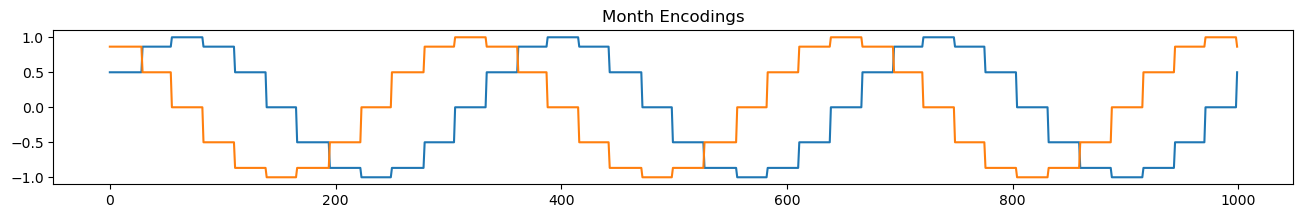

,month_sin_encoding,month_cos_encoding,weekday_sin_encoding,weekday_cos_encoding,hour_sin_encoding,hour_cos_encoding,minute_sin_encoding,minute_cos_encoding
0,0.5,0.866025,0.974928,-0.222521,0.000000,1.000000,0.000000,1.000000
1,0.5,0.866025,0.433884,-0.900969,0.500000,0.866025,0.913545,-0.406737
2,0.5,0.866025,-0.433884,-0.900969,0.866025,0.500000,-0.809017,-0.587785


In [5]:
time_range = get_time_range('2020-01-01 00:00', '2023-01-01 00:00')
values = [datetime_encoder(d) for d in time_range]
df = pd.DataFrame(values)

plt.figure(figsize=(16,2))
plt.plot(df['month_sin_encoding'], label='sin')
plt.plot(df['month_cos_encoding'], label='cos')
plt.title('Month Encodings')
plt.show()

df.head(3)

### Show Cyclical Weekdays

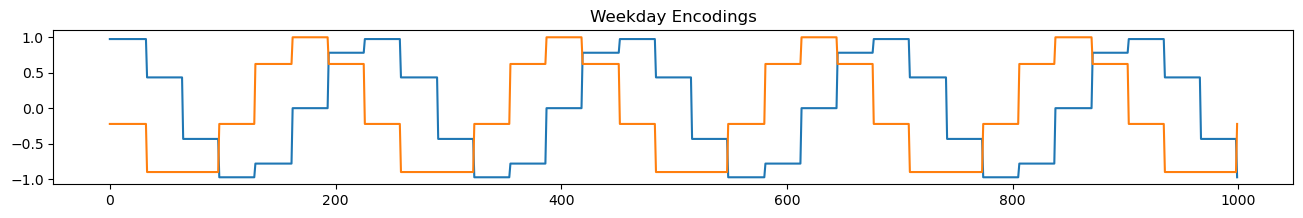

,month_sin_encoding,month_cos_encoding,weekday_sin_encoding,weekday_cos_encoding,hour_sin_encoding,hour_cos_encoding,minute_sin_encoding,minute_cos_encoding
0,0.5,0.866025,0.974928,-0.222521,0.000000,1.000000,0.000000,1.000000
1,0.5,0.866025,0.974928,-0.222521,0.000000,1.000000,-0.994522,-0.104528
2,0.5,0.866025,0.974928,-0.222521,0.258819,0.965926,0.104528,-0.994522


In [6]:
time_range = get_time_range('2020-01-01 00:00', '2020-02-01 00:00')
values = [datetime_encoder(d) for d in time_range]
df = pd.DataFrame(values)

plt.figure(figsize=(16,2))
plt.plot(df['weekday_sin_encoding'], label='sin')
plt.plot(df['weekday_cos_encoding'], label='cos')
plt.title('Weekday Encodings')
plt.show()

df.head(3)

### Show Cyclical Hours

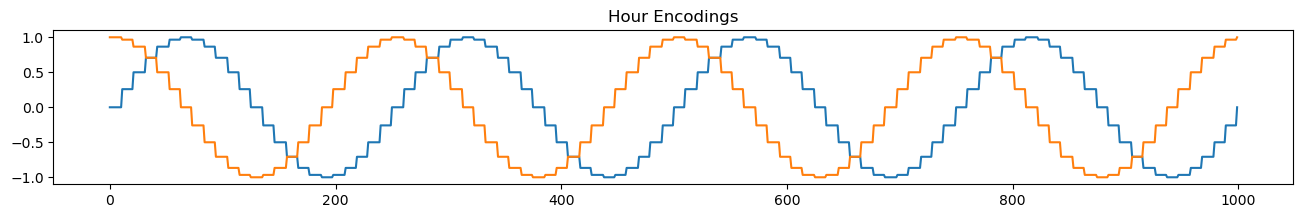

,month_sin_encoding,month_cos_encoding,weekday_sin_encoding,weekday_cos_encoding,hour_sin_encoding,hour_cos_encoding,minute_sin_encoding,minute_cos_encoding
0,0.5,0.866025,0.974928,-0.222521,0.0,1.0,0.000000,1.000000
1,0.5,0.866025,0.974928,-0.222521,0.0,1.0,0.500000,0.866025
2,0.5,0.866025,0.974928,-0.222521,0.0,1.0,0.913545,0.406737


In [7]:
time_range = get_time_range('2020-01-01 00:00', '2020-01-05 00:00')
values = [datetime_encoder(d) for d in time_range]
df = pd.DataFrame(values)

plt.figure(figsize=(16,2))
plt.plot(df['hour_sin_encoding'], label='sin')
plt.plot(df['hour_cos_encoding'], label='cos')
plt.title('Hour Encodings')
plt.show()

df.head(3)

### Show Cyclical Minutes

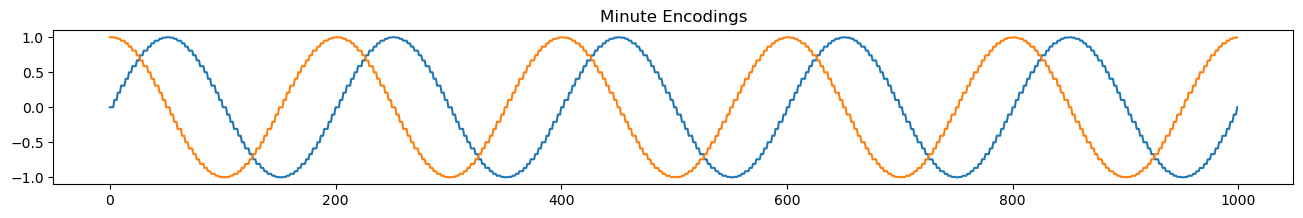

,month_sin_encoding,month_cos_encoding,weekday_sin_encoding,weekday_cos_encoding,hour_sin_encoding,hour_cos_encoding,minute_sin_encoding,minute_cos_encoding
0,0.5,0.866025,0.974928,-0.222521,0.0,1.0,0.0,1.0
1,0.5,0.866025,0.974928,-0.222521,0.0,1.0,0.0,1.0
2,0.5,0.866025,0.974928,-0.222521,0.0,1.0,0.0,1.0


In [8]:
time_range = get_time_range('2020-01-01 00:00', '2020-01-01 05:00')
values = [datetime_encoder(d) for d in time_range]
df = pd.DataFrame(values)

plt.figure(figsize=(16,2))
plt.plot(df['minute_sin_encoding'], label='sin')
plt.plot(df['minute_cos_encoding'], label='cos')
plt.title('Minute Encodings')
plt.show()

df.head(3)

## Additional Notes

### Things that should not be cyclical encoded

Cyclical encodings can be expected to work well when for variables that operate on a cycle and when neighboring groups are closely related. 

For example 
- year is not cyclic, and numerical encodings would be more appropriate
- weekdays are cyclic, however there are relatively few of them and the relationship between days may be inconsistent. For example, behavior on a sunday vs a monday might be more different than a tuesday vs thursday. This means that onehot encoding weekdays may be more appropriate.

### Alternatives to sin/cos encodings
There has been some discussion of alternative functions for positional encoding

For example, while not popular, this paper discusses alternative encodings for timeseries: https://arxiv.org/pdf/2305.16642.pdf